In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

from datetime import datetime




In [221]:
pd.options.mode.chained_assignment = None

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from scipy import stats

In [23]:
NY_airbnb = pd.read_pickle("./NY_airbnb_clean.pkl")

In [94]:
NY_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19573 entries, 1 to 36854
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              19573 non-null  int64         
 1   host_since                      19573 non-null  datetime64[ns]
 2   host_response_time              19573 non-null  object        
 3   host_is_superhost               19573 non-null  int64         
 4   host_total_listings_count       19573 non-null  float64       
 5   host_has_profile_pic            19573 non-null  int64         
 6   host_identity_verified          19573 non-null  int64         
 7   neighbourhood                   19573 non-null  object        
 8   region                          19573 non-null  object        
 9   latitude                        19573 non-null  float64       
 10  longitude                       19573 non-null  float64       
 11  ro

In [95]:
NY_airbnb.columns

Index(['id', 'host_since', 'host_response_time', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'region', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms',
       'beds', 'price', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'first_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count', 'description_len',
       'neighborhood_overview_len', 'host_state_NY', 'host_about_len',
       'host_response_rate_per', 'host_proffesional',
       'host_verifications_count', 'accomodates_level', 'bathroom_type',
       'Parking', 'amenities_count', 'short_term_rental',
      

In [59]:
NY_airbnb['neighbourhood'].value_counts()

Williamsburg          1503
Bedford-Stuyvesant    1487
Harlem                1019
Bushwick               878
Upper West Side        717
                      ... 
Country Club             1
Tottenville              1
Westerleigh              1
Bull's Head              1
Arden Heights            1
Name: neighbourhood, Length: 215, dtype: int64

# Occupancy rate


This project will analyze the Airbnb listings and identify critical features that mostly affect the occupancy rate of a listing. The result of the analysis will help hosts in optimizing their listings and will increase the occupancy rates. Optimizing listings will eventually improve both hosts and guests experiences and yield higher retention.

The occupancy rates for each listing is estimated as a function of the average number of reviews per month and minimum required nights. Occupancy level is derived from occupancy rates and divide listings as high, average and low occupancy considering the following industry occupancy levels. 
-- The U.S. average occupancy rate is about 46.% by April, 2021.
-- An ideal occupancy rate for hotels is between 70% and 95%.




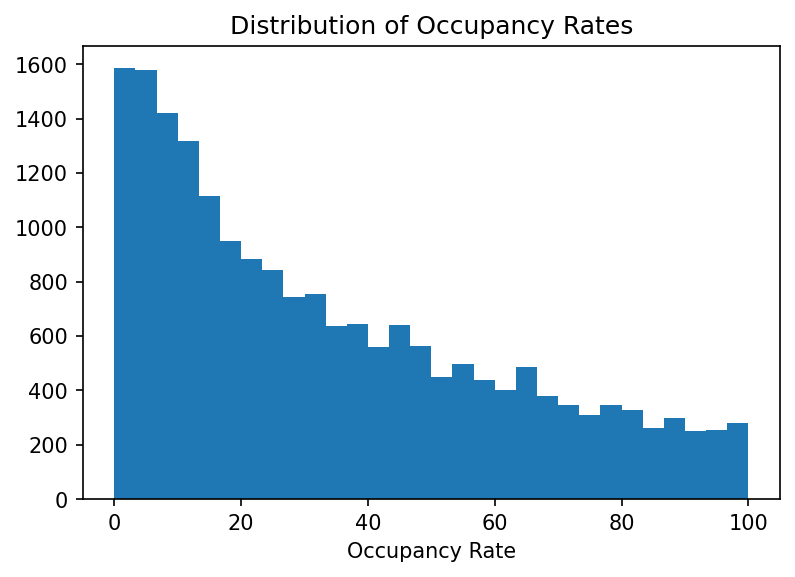

In [27]:
plt.figure(dpi=150)
plt.hist(NY_airbnb.occupancy_rate, bins=30, range= (0,100))
plt.title('Distribution of Occupancy Rates')
plt.xlabel('Occupancy Rate')

plt.savefig('occupancy_hist.png')

In [26]:
NY_airbnb.occupancy_rate.describe()

count    19573.000000
mean        34.641223
std         26.997818
min          0.109589
25%         11.178082
50%         27.397260
75%         53.150685
max         99.945205
Name: occupancy_rate, dtype: float64

In [29]:
print('90 percentile of occupancy rate', np.percentile(NY_airbnb.occupancy_rate,90))
print('95 percentile of occupancy rate', np.percentile(NY_airbnb.occupancy_rate,95))


90 percentile of occupancy rate 76.93150684931506
95 percentile of occupancy rate 88.37260273972579


In [31]:
mask1 = NY_airbnb.occupancy_rate > np.percentile(NY_airbnb.occupancy_rate,90)
mask2 = NY_airbnb.occupancy_rate > np.percentile(NY_airbnb.occupancy_rate,95)
#mask3 = NY_airbnb.occupancy_rate <= np.percentile(NY_airbnb.occupancy_rate,90) & NY_airbnb.occupancy_rate > np.percentile(NY_airbnb.occupancy_rate,70)

In [34]:
print('The number of listings with higher than 90% occupancy rate',NY_airbnb[mask1].shape[0])
print('The number of listings with higher than 95% occupancy rate',NY_airbnb[mask2].shape[0])

The number of listings with higher than 90% occupancy rate 1951
The number of listings with higher than 95% occupancy rate 979


In [56]:
NY_airbnb['occupancy_level'] = pd.cut(NY_airbnb.occupancy_rate, 
                               bins=[0, 46, 70, 100], 
                               labels=['low', 'average', 'high'], 
                               include_lowest=True)

In [57]:
NY_airbnb['occupancy_level'].value_counts()

low        13347
average     3553
high        2673
Name: occupancy_level, dtype: int64

low        13347
average     3553
high        2673
Name: occupancy_level, dtype: int64


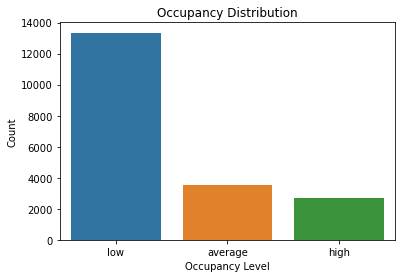

In [58]:
print(NY_airbnb.occupancy_level.value_counts())

#plt.figure(dpi=150)
plt = sns.countplot(x="occupancy_level", data =NY_airbnb)
plt.set(xlabel='Occupancy Level', ylabel='Count', title = 'Occupancy Distribution')

plt.figure.savefig('occupancy_nominal.png',dpi =300)


# Classification evaluation metric

Precision is important to categorize the listings correctly. If hosts know, their listings would create high or low occupancy, they would act differently. For example, a host with a low predicted occupancy might invest in various sources and search methods to increase the occupancy rate. So, it is important to provide the right information to the host. 

On the other hand, recall is also relevant in this concept. Identifing a high occupancy listing as lower category causes additional costs to the listing host who aims to improve his listings occupancy as well as his profit and might affect adversely the host's revenue from the Airbnb platform. Eventually, this, false negatives, rises the host churn rate from the platform. 

The other point need to be considered before picking an evaluation metric is the nature of the target feature. The occupancy level is multiclass and imbalanced. As stated above, I will take a balanced approach between precision and recall with more weight to precision. So, I will use F1 beta metric to evaluate the model performance with an average option 'weighted' to account for label imbalance.  

The model will be evaluated candidate models using repeated stratified k-fold cross-validation.

- Stratified means that each fold will aim to contain the same mixture of examples by class as the entire training dataset. Repeated means that the evaluation process will be performed multiple times to help avoid fluke results and better capture the variance of the chosen model. We will use three repeats( link:)[https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/]



# EDA and Baseline model

In [99]:
listings = NY_airbnb[['id', 'host_since', 'host_response_time', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'region', 'room_type', 'accommodates','room_type', 'accommodates','bedrooms',
       'beds', 'price', 'availability_365',
       'number_of_reviews','review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'description_len', 'neighborhood_overview_len', 'host_state_NY', 'host_about_len',
       'host_response_rate_per', 'host_proffesional',
       'host_verifications_count', 'accomodates_level', 'bathroom_type',
       'Parking', 'amenities_count',
       'short_term_rental', 'time_since_last_review_bin', 'occupancy_level']]

In [80]:
#listings['host_response_time'] = listings['host_response_time'].astype('category')

In [100]:
listings.shape # There are total 40 features to predict occupancy level

(19573, 38)

In [69]:
def get_pairplot_cols(df, first_col, last_col):
    sns.set_style("whitegrid", {'axes.grid' : False})
    #plt.figure()
    cols_to_plot = df.columns[first_col:last_col-1].tolist() + ['occupancy_level'] # explicitly add the column "top_listing" to your list of columns to plot
    sns.pairplot(df[cols_to_plot], hue ='occupancy_level')
   

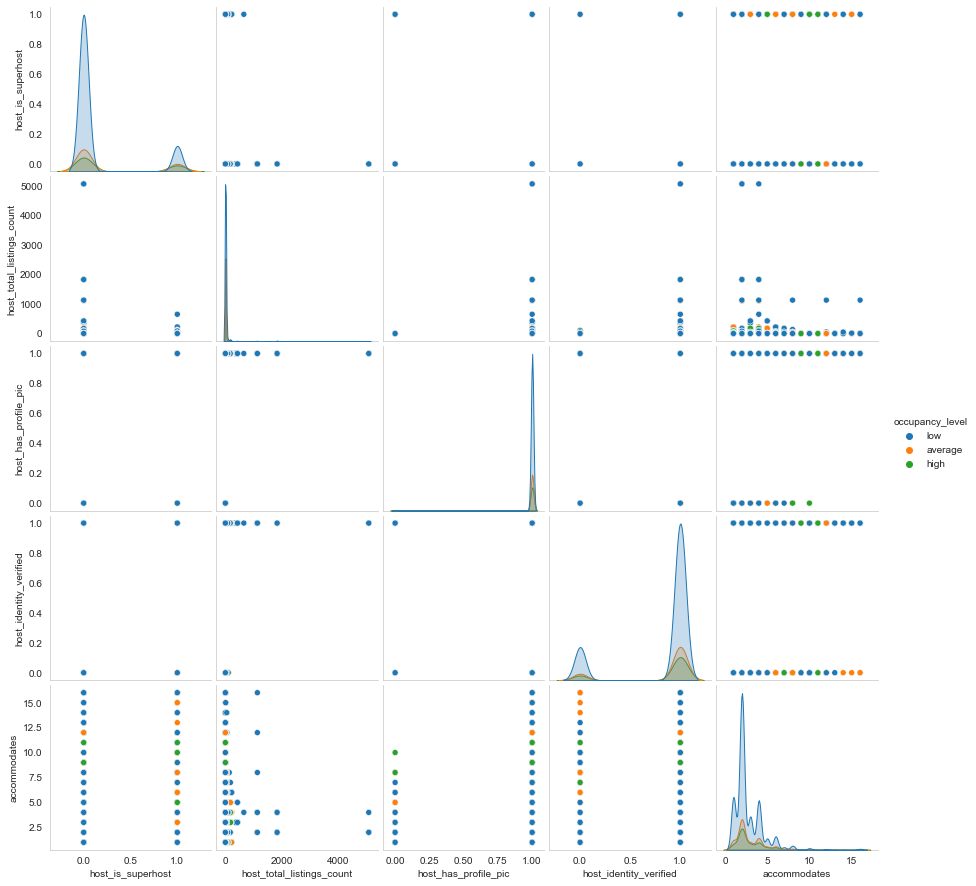

In [81]:
get_pairplot_cols(listings, 1,11)

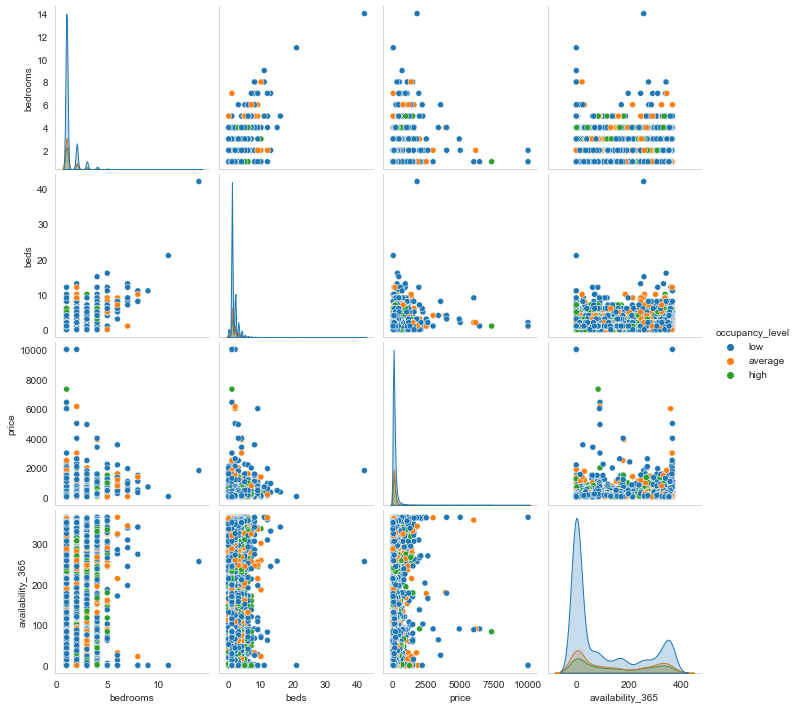

In [84]:
get_pairplot_cols(listings, 11,16)

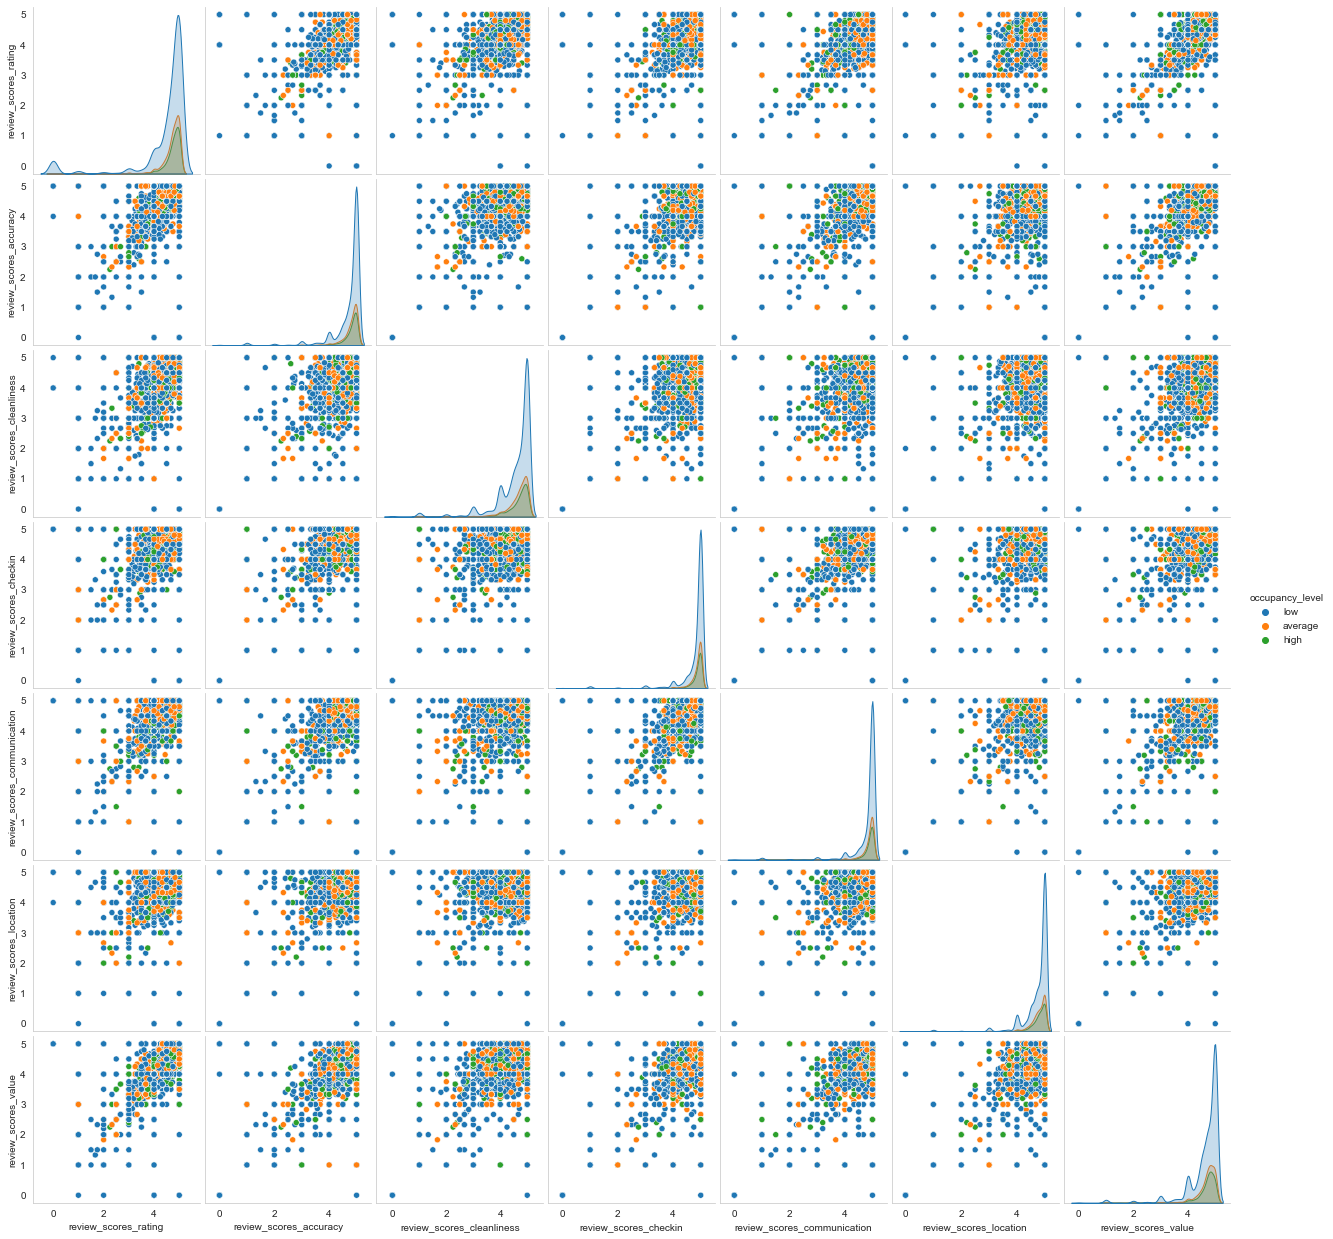

In [87]:
get_pairplot_cols(listings, 16,24)

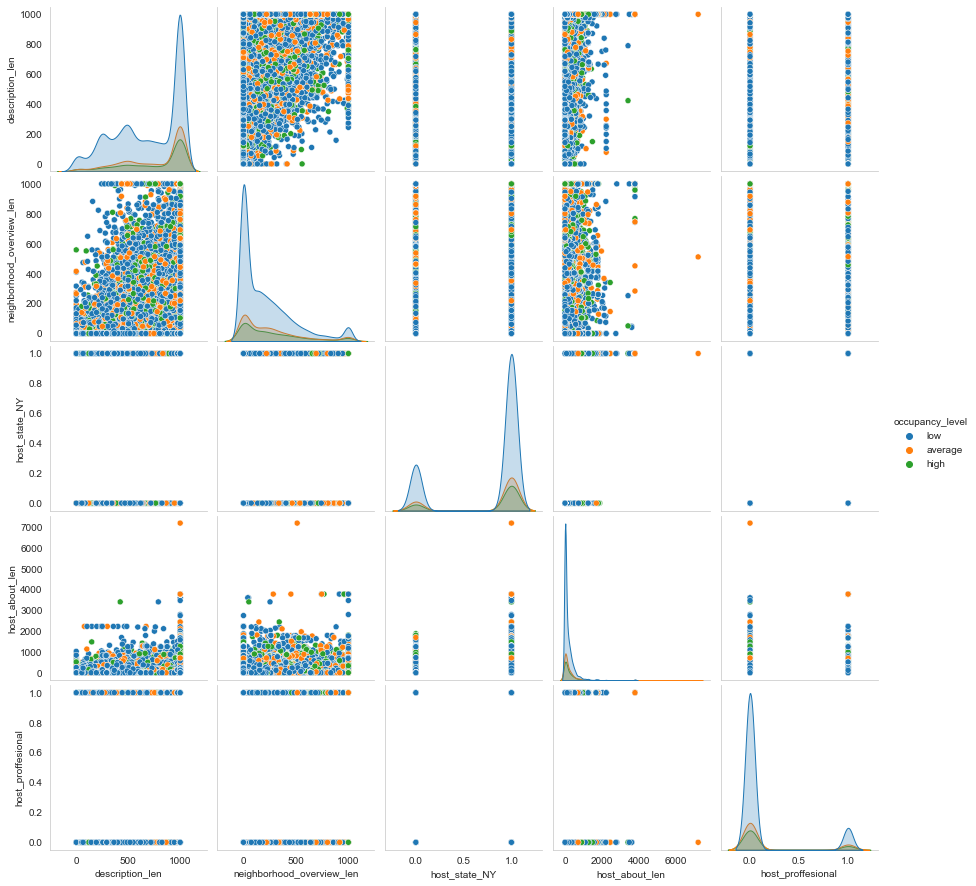

In [88]:
get_pairplot_cols(listings, 24,31)

In [91]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

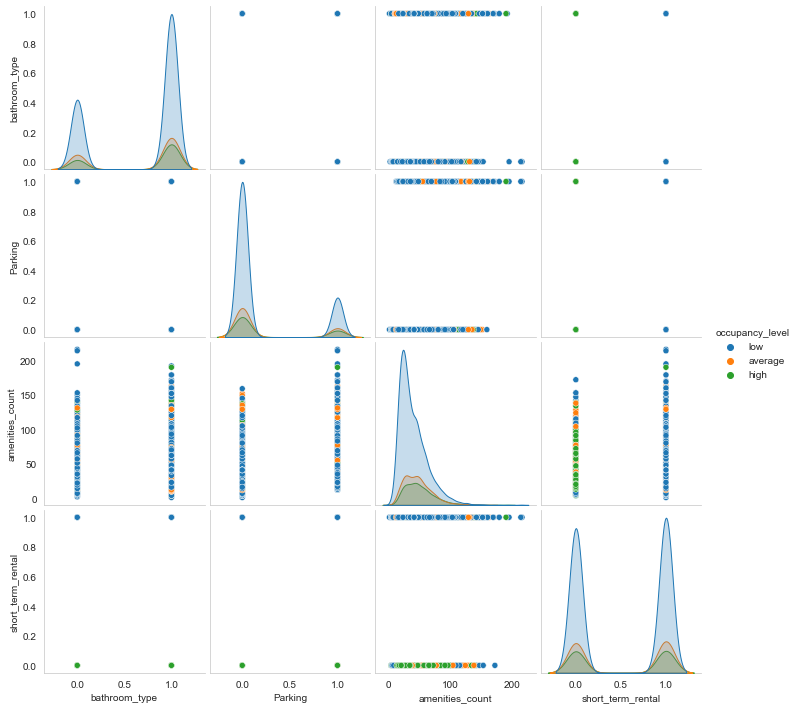

In [101]:
get_pairplot_cols(listings, 31,38)

<AxesSubplot:xlabel='accomodates_level', ylabel='count'>

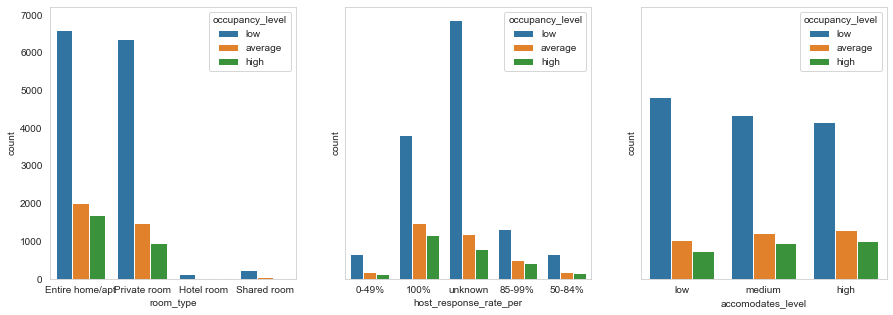

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.countplot(ax=axes[0],x =listings['room_type'], hue = listings.occupancy_level)
#axes[0].set_title()

sns.countplot(ax=axes[1],x =listings['host_response_rate_per'], hue = listings.occupancy_level)
#axes[1].set_title()

sns.countplot(ax=axes[2],x =listings['accomodates_level'], hue = listings.occupancy_level)


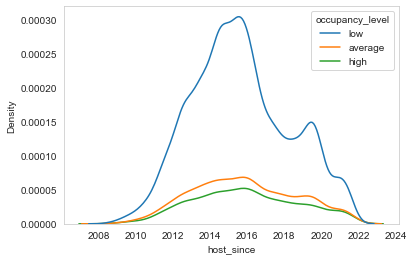

In [117]:
sns.kdeplot(data=listings, x='host_since',hue ='occupancy_level');

In [125]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask=mask[1:,:-1]
    corr = corr.iloc[1:,:-1].copy()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

C:\Users\12157\AppData\Local\Temp/ipykernel_16396/3293059936.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


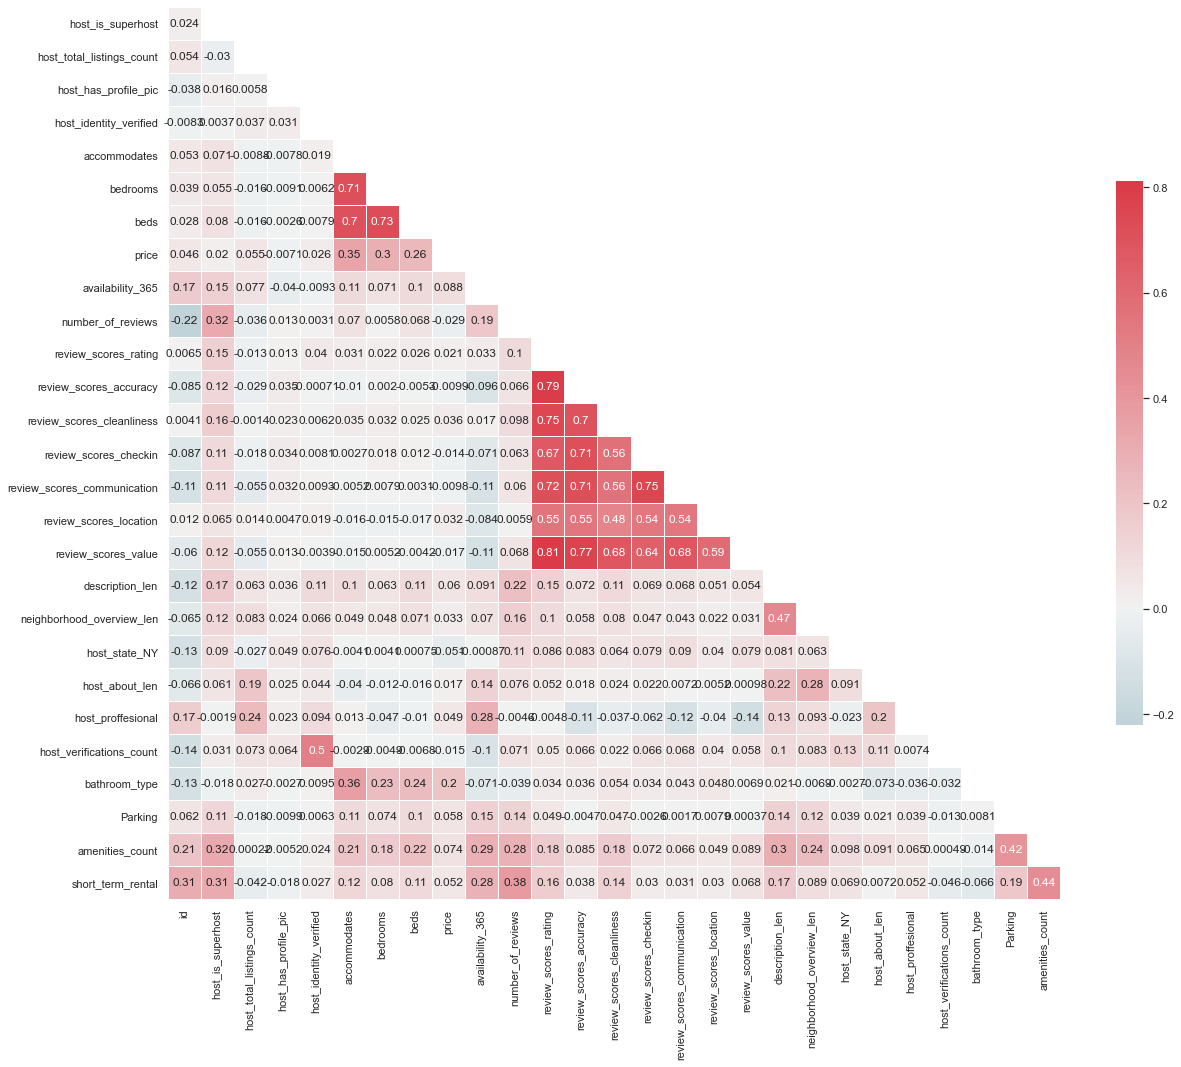

In [126]:
multi_collinearity_heatmap(listings, figsize=(20,20))

# Baseline model

Split data in X and y and normalize data with StandardScaler: 

In [143]:
X_base = listings[['host_response_rate_per','amenities_count','neighborhood_overview_len','availability_365','host_proffesional']]
X_base.shape

(19573, 5)

In [248]:
listings['host_response_rate_per'].value_counts()

unknown    8871
100%       6467
85-99%     2273
50-84%      988
0-49%       974
Name: host_response_rate_per, dtype: int64

In [132]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV

In [157]:
from sklearn.metrics import cohen_kappa_score

In [133]:
# label encode the target variable
y = listings['occupancy_level']
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
#class 0, low
#class 1, high
#class 2, low

Class=0, n=3553 (18.153%)
Class=2, n=13347 (68.191%)
Class=1, n=2673 (13.657%)


In [197]:
X_base['host_response_rate_label'] = LabelEncoder().fit_transform(X_base['host_response_rate_per'])
X_base.drop('host_response_rate_per', axis = 1, inplace = True)
X_base.head()

,amenities_count,neighborhood_overview_len,availability_365,host_proffesional,host_response_rate_label
1,74,258.0,208,0,0
3,29,0.0,204,0,0
4,37,47.0,243,0,1
5,31,74.0,0,0,4
6,113,491.0,333,0,1


In [234]:
#split data
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y, test_size = 0.2, random_state=42)


In [235]:
X_base_train.shape

(15658, 5)

In [238]:
scaler = StandardScaler()

X_base_train_scaled = scaler.fit_transform(X_base_train)
X_base_test_scaled = scaler.transform(X_base_test)


In [239]:
X_base_train_scaled.shape

(15658, 5)

In [230]:
# evaluate a model
def evaluate_model(X, y, model):
    ftwo_scorer = make_scorer(fbeta_score, beta=0.75, average='weighted')
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring=ftwo_scorer, cv=cv, n_jobs=-1)
    return scores 
   

In [245]:
model_knn = KNeighborsClassifier(n_neighbors=2)
# evaluate the model
scores = evaluate_model(X_base_train_scaled, y_base_train, model)
#print(scores)
# summarize performance
print('KNN (K=2) | Baseline Test F1 beta score:  %.3f  \t' % (np.mean(scores)))

KNN (K=2) | Baseline Test F1 beta score:  0.564  	


In [246]:
model = RandomForestClassifier(n_estimators=100,class_weight='balanced')
# evaluate the model
scores = evaluate_model(X_base_train_scaled, y_base_train, model)

#print(scores)
# summarize performance
print('Random Forest (n=100) | Baseline Test F1 beta score:  %.3f  \t' % (np.mean(scores)))

Random Forest (n=100) | Baseline Test F1 beta score:  0.564  	


In [217]:
knn_baseline = KNeighborsClassifier(n_neighbors=20)
knn_baseline.fit(X_train, y_train)

# knn -- compute prediction on testing data
knn_y_pred = knn_baseline.predict(X_test_scaled)

# knn - score model based on standard accuracy metric and f1 beta score (metric to optimize for in my model) 
knn_accuracy_baseline = knn_baseline.score(X_test_scaled, y_test)
knn_fbeta_baseline = fbeta_score(y_test, knn_y_pred, beta=0.35) # favoring precision (see rationale above)



f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].